<a href="https://colab.research.google.com/github/neimarcos/Mestrado/blob/main/prototipo_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testes iniciais com grafico simples, feito na mão no exemplo

In [186]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.2 MB 4.7 MB/s 


/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


KeyError: ignored

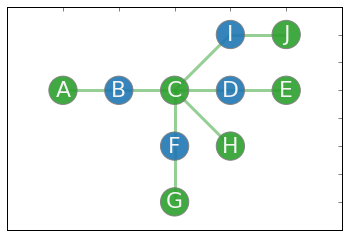

In [221]:
from logging import Handler
from numpy.lib.function_base import append
#!sudo pulptest
import matplotlib.pyplot as plt
import networkx as nx
from networkx.readwrite import json_graph
from pprint import pprint
import matplotlib.patches as mpatches
from IPython.lib.display import FileLinks
from IPython.lib.display import FileLinks
# Import PuLP modeler functions
from pulp import *

G = nx.Graph()
pos = {0: (0,0), 1:(1,0) , 2: (2,0), 3: (3, 0), 4: (4, 0), 5: (2, -1), 6: (2, -2), 7: (3, -1), 8: (3, 1), 9: (4, 1)}
node_labels = { 0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H", 8: "I", 9: "J"}

G.add_nodes_from(node_labels)
G.add_edges_from([(0, 1),(1, 2),(2, 3),(3, 4),(2, 5),(2, 7),(5, 6),(2, 8),(8, 9)])


betweenness_centrality = nx.betweenness_centrality(G)
#pprint('betweenness_centrality')


all_values = betweenness_centrality.values()
max_value = max(all_values)

# If a node is a probe station, then the color is green else it is  blue
nodes_color = []
for x in betweenness_centrality:
  if betweenness_centrality[x]==0 or betweenness_centrality[x]==max_value:
    nodes_color.append("tab:green")    
  else:
    nodes_color.append("tab:blue")



# nodes
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
nx.draw_networkx_nodes(G, pos, nodelist=[ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], node_color=nodes_color, **options)

# edges
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=G.edges,
    width=3,
    alpha=0.5,
    edge_color="tab:green",
)


nx.draw_networkx_labels(G, pos, node_labels, font_size=22, font_color="whitesmoke")
nx.write_graphml(G,"saida")



# Creates a dictionary for the number of probes in each host
supply = {}

for nodes in G:
  if nodes_color[nodes]!='tab:blue':
    arestas= G.edges(nodes)
    supply[nodes]=len(arestas)

# Creates a list of all demand nodes
Probes = []
# Creates a dictionary for the number of units of demand for each demand node
demand = {}

for POS, DADO in node_labels.items():
  for POS2, DADO2 in node_labels.items():
    if POS < POS2:
      if nodes_color[POS]!='tab:blue':
        Probes.append(DADO+DADO2)
        demand[DADO+DADO2]=1;


# Creates a list of costs of each probe path
costs = []
links = []
Routes= []

possible_probes = []

for node in G.nodes:
  linhacosts = []
  linhalinks = []
  if nodes_color[node]!='tab:blue':
    Routes.append(node_labels[node])
    for probe in Probes:
      if (node_labels[node] in probe):
        myTuple = (node_labels[node],probe)
        possible_probes.append(myTuple)
        linhacosts.append(len(G.edges(node)))
        linhalinks.append(1)
      else:
        linhacosts.append(0)
        linhalinks.append(1)
    costs.append(linhacosts)
    links.append(linhalinks)

# The cost data is made into a dictionary
costs = makeDict([Routes,Probes],costs,0)



# Creates the 'prob' variable to contain the problem data
prob = LpProblem("Probes Placement Problem",LpMaximize)

#print (possible_probes)
# A dictionary called 'Vars' is created to contain the referenced variables(the routes)
vars = LpVariable.dicts("Route",(Routes,Probes),0,None,LpInteger)


# The objective function is added to 'prob' first
#tmp1 = lpSum([vars[w][b]*costs[w][b] for (w,b) in possible_probes])
#tmp2 = lpSum([vars[w][b]*costs[w][b] for (w,b) in possible_probes])
prob +=  lpSum([vars[w][b]*costs[w][b] for (w,b) in possible_probes]), "Sum_of_Transporting_Costs"


# The supply maximum constraints are added to prob for each supply node (routes)
for w in Routes:
    Probes_in_Route = []
    for j in range(9):
      if (links[Routes.index(w)][j] > 0): 
        Probes_in_Route.append(Probes[j])
    prob += lpSum([vars[w][b] for b in Probes_in_Route])<=supply[w], "Sum_of_Probes_out_of_route_%s"%w

# The demand minimum constraints are added to prob for each demand node (probes)
for b in Probes:
    Probes_in_Route = []
    for j in range(6):
      if (links[j][Probes.index(b)] > 0): 
        Probes_in_Route.append(Routes[j])
    prob += lpSum([vars[w][b] for w in Probes_in_Route])==demand[b], "Sum_of_Products_into_Bar%s"%b


# The problem data is written to an .lp file
prob.writeLP("ProbesPlacement.lp")

# The problem is solved using PuLP's choice of Solver
prob.solve()

# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])

# Each of the variables is printed with it's resolved optimum value
for v in prob.variables():
    #if v.varValue > 0:
      print(v.name, "=", v.varValue)

# The optimised objective function value is printed to the screen    
print("Total Cost = ", value(prob.objective))


      
#pprint(Probes)
#pprint(demand)
plt.tight_layout()
plt.axis("off")
plt.show()

# Save graph





